In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pink_utils as pu
import pickle 

In [6]:
ed = pu.heatmap('../Create_Map/Layer_1/F1W1_95_5_L1_ED.bin')
df = pd.read_csv('../Create_Map/Layer_1/F1W1_95_5_Sources.csv')

/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def ed_to_prob(data: np.ndarray, stretch: float=1.):
    """Convert the Euclidean distance matrix from PINK to a proability like matrix
    
    Arguments:
        data {np.ndarray} -- Three dimension all of Euclidean distances [NImages, height, width]
    
    Keyword Arguments:
        thresh {float} -- Stretching parameter to introduce non-linearity (default: {1.})
    
    Returns:
        np.ndarray -- Probability matrix of shape [NImages, height, width]
    """

    assert len(data.shape) == 3, 'Length not correct'
    
    prob = data - data.min(axis=(1,2))[:, None, None]
    prob = 1. / (1. + prob)**stretch
    prob = prob / prob.sum(axis=(1,2))[:, None, None]
    
    return prob

def target_prob(prob: np.ndarray, mask: np.ndarray, match: float, negate: bool=False):
    """Derive and apply the probability of an object matching a label region
    
    Arguments:
        prob {np.ndarray} -- Probability matrix of shape [NImage, height, width]
        mask {np.ndarray} -- Mask of label region
        match {float} -- Matching level a object needs to be included
        
    Keyword Arguments:
        negate {bool} -- Negate the matching criteria (default: {1})
    
    Returns:
        {np.ndarray} -- Matching probabilities for all objects
        {np.ndarray} -- Indicies matching the criteria
    """
    match_prob = prob[:,mask].sum(axis=1)
    match_pos  = match_prob > match

    if negate:
        match_pos = ~match_pos

    return match_prob, np.argwhere(match_pos).T[0]

def make_mask(label: dict, target: str, shape: tuple, fill_val: int=1):
    """Produce a numpy mask array based on the location of labels matching
    the target in the `label` dictionary.  
    
    Arguments:
        label {dict} -- Dictionary whose keys are the location of the corresponding label valu
        target {str} -- Desired target value to make mask for
        shape {tuple} -- Shape of SOM map. TODO: Include this in label structure
    
    Keyword Arguments:
        fill_val {int} -- Value to place in array when match found (default: {1})
    
    Returns:
        [np.ndarray] -- Masking array
    """

    mask = np.zeros(shape, dtype=type(fill_val))
    for pos in label:
        if label[pos] == target:
            mask[pos] = fill_val

    return mask

def som_size(labels: dict):
    """Find the size of the SOM. Assume a quad shape
    
    Arguments:
        labels {dict} -- The annotated labels of the SOM map. Keys are positions. 
    """
    pos = 0
    key = (0,0)
    for p in labels.keys():
        if np.prod(p) > pos:
            key = p
    
    return [k+1 for k in key]


In [8]:
labels = pickle.load(open('../Create_Map/Layer_1/F1W1_95_5_L1_SOM_Annotation_labels.pkl', 'rb'))
som_shape = som_size(labels)
mask = make_mask(labels, '0', som_shape, fill_val=True)

In [30]:
prob = ed_to_prob(ed.data, stretch=1)
match_prob, match_idx = target_prob(prob, mask, 0.7, negate=False)
df['match_prob'] = match_prob

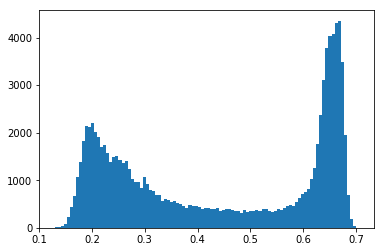

In [31]:
fig, ax = plt.subplots(1,1)

ax.hist(df['match_prob'], bins=100)

fig.show()

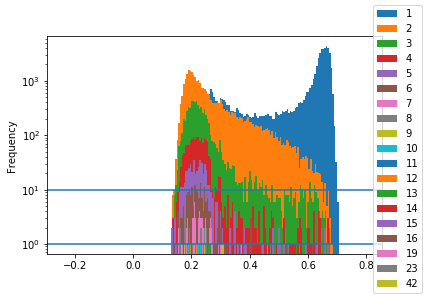

In [34]:
fig, ax = plt.subplots(1,1)

df.groupby('radio.number_peaks')['match_prob'].plot(kind='hist', bins=100, stacked=True, ax=ax, log=True)

ax.axhline(1)
ax.axhline(10)

fig.legend()
fig.show()